In [9]:
from chess import Board, pgn
from auxiliary_func import board_to_matrix
import torch
from model4 import ChessModel4
from MiniMaia import MiniMaia
import pickle
import numpy as np
import random
import chess

# Predictions

1. Prepare the Input Data
Convert the board state to a format suitable for the model:

In [3]:
def prepare_input(board: Board):
    matrix = board_to_matrix(board)
    X_tensor = torch.tensor(matrix, dtype=torch.float32).unsqueeze(0)
    return X_tensor

2. Load the Model & mapping and Move to GPU if Available

In [708]:
# Load the mapping

with open("../../models/flipped_board_data_move_to_int", "rb") as file:
    move_to_int = pickle.load(file)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Load the model
model = ChessModel4(num_classes=len(move_to_int))
model.load_state_dict(torch.load("../../models/flipped_boards_model_final_model.pth"))
model.to(device)
model.eval()

# model 2
model2 = MiniMaia(num_classes=len(move_to_int), num_blocks=8)
model2.load_state_dict(torch.load("../../models/testing_finetuning_final_model.pth"))
model2.to(device)
model.eval()

int_to_move = {v: k for k, v in move_to_int.items()}
print(int_to_move)
# Function to make predictions
def predict_move(board: Board, pseudo_temp: int = 1):

    X_tensor = prepare_input(board).to(device)
    
    with torch.no_grad():
        logits = model2(X_tensor)
    
    logits = logits.squeeze(0)  # Remove batch dimension
    
    probabilities = torch.softmax(logits, dim=0).cpu().numpy()  # Convert to probabilities
    argsort = np.argsort(probabilities)[::-1] # record what moves sorted probs correspond to


    sorted_probs = probabilities
    sorted_probs.sort()
    sorted_probs = sorted_probs[::-1]
    legal_moves = list(board.legal_moves)
    legal_moves_uci = [move.uci() for move in legal_moves]
    # sorted_indices = np.argsort(probabilities)[::-1]
    for i in range(10): # try finding a legal move 10 times first
        selection = random.random() ** pseudo_temp
        collective_sum = 0
        idx = 0
        for prob in sorted_probs:
            # print(prob)
            collective_sum += prob
            if selection < collective_sum:
                move = int_to_move[argsort[idx]]
                if move in legal_moves_uci:
                    return move
                else:
                    break
            idx += 1

    idx = 0
    for prob in sorted_probs:
        move = int_to_move[argsort[idx]]
        if move in legal_moves_uci:
            return move
        idx += 1
    return None

Using device: cuda
{0: 'h6g4', 1: 'e8d7', 2: 'b1b3', 3: 'd5e5', 4: 'h2h1q', 5: 'b3a4', 6: 'b7h7', 7: 'e3a7', 8: 'c5d5', 9: 'f8f5', 10: 'g4f4', 11: 'f1h3', 12: 'd4e3', 13: 'a2a1q', 14: 'e2d4', 15: 'h3h4', 16: 'a5a4', 17: 'c6c2', 18: 'b3b4', 19: 'e3f4', 20: 'b2b8', 21: 'e4e7', 22: 'e2e1q', 23: 'f6g4', 24: 'a6b8', 25: 'e2e5', 26: 'g7c7', 27: 'e1e8', 28: 'd7d2', 29: 'g2h1r', 30: 'd3a6', 31: 'a3b5', 32: 'c4d2', 33: 'f7g8', 34: 'a2a1b', 35: 'c6g6', 36: 'a4d4', 37: 'd7d8', 38: 'a1b1', 39: 'f4f3', 40: 'e3d4', 41: 'a8c8', 42: 'h6e6', 43: 'f2h1', 44: 'e5g7', 45: 'g8c4', 46: 'a2e2', 47: 'b1c3', 48: 'd5c5', 49: 'g7h8', 50: 'b6a8', 51: 'd6f8', 52: 'f6f7', 53: 'h3h1', 54: 'f6e5', 55: 'c4d6', 56: 'c3c5', 57: 'd5b6', 58: 'f1f8', 59: 'e6d8', 60: 'b3a3', 61: 'h6f6', 62: 'g5g7', 63: 'g2g1', 64: 'h3g4', 65: 'e1c2', 66: 'd5f3', 67: 'c7c4', 68: 'f3g4', 69: 'c7b8q', 70: 'g7h6', 71: 'g8c8', 72: 'e7f8n', 73: 'g7a7', 74: 'c3c8', 75: 'a6a5', 76: 'b8b1', 77: 'h7c2', 78: 'f6f1', 79: 'f4g4', 80: 'd2d7', 81: 'd1f1',

3. Use the ```predict_move``` function to get the best move and its probabilities for a given board state:

In [612]:
# Initialize a chess board
board = Board()

In [611]:
# Clear board
board.clear()

# Place pieces: White King e4, Pawn d5; Black King e7
board.set_piece_at(chess.E4, chess.Piece(chess.KING, chess.WHITE))
board.set_piece_at(chess.D5, chess.Piece(chess.PAWN, chess.WHITE))
board.set_piece_at(chess.E7, chess.Piece(chess.KING, chess.BLACK))

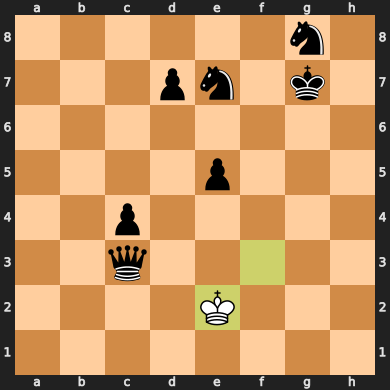

In [578]:
board

In [139]:

board.push_uci("d8e8")


IllegalMoveError: illegal uci: 'd8e8' in 8/4k3/8/3P4/4K3/8/8/8 w - - 0 1

b6b8


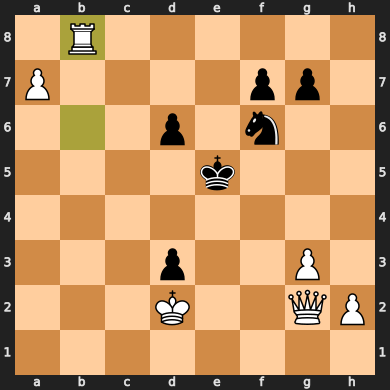

In [706]:
# Predict and make a move
best_move = predict_move(board)
print(best_move)
board.push_uci(best_move)
board

In [ ]:
print(str(pgn.Game.from_board(board)))